In [1]:
import numpy as np
import commpy as cp
from commpy.channelcoding import convcode, Trellis
from deepcom.utils import corrupt_signal
from deepcom.dataset import generate_message_bits

# For visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
BLOCK_LEN = 100
SNR_MIN   = -10
SNR_MAX   = 10
SNR       = SNR_MAX  # desired SNR used to determine noise power
Eb_No     = 10**(SNR/10.0) # convert SNR to decimal
No        = 1.0/Eb_No # Linear power of the noise; average signal power = 1 (0dB)

trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7, 
                  code_type= 'rsc')
QPSKModem = cp.modulation.PSKModem(m=32)

In [3]:
# Helper function to visualize complex signals
def visualize(signals, axScatter, axHistx, axHisty, title):
    
    # Scatter Plot
    axScatter.scatter(np.real(signals), np.imag(signals))
    axScatter.axhline(0, color='black')
    axScatter.axvline(0, color='black')
    
    axScatter.set_xlabel(title)
    # no axis labels for box plots
    axHistx.xaxis.set_visible(False)
    axHisty.yaxis.set_visible(False)
    binwidth = 0.25 # width of histrogram 'bins'
    xymax = np.max([np.max(np.fabs(np.real(signals))), 
                    np.max(np.fabs(np.imag(signals)))] ) # find abs max symbol value; nominally 1 
    lim = (int(xymax/binwidth) + 1) * binwidth # create limit that is one 'binwidth' greater than 'xymax'
    
    # set the data limits for the axes
    axScatter.set_xlim((-lim, lim)) 
    axScatter.set_ylim((-lim, lim))
    
    # create bins 'binwidth' apart between -lin and +lim -- autoscale
    bins = np.arange(-lim, lim + binwidth, binwidth) 

    # Histogram Plot
    axHistx.hist(np.real(signals), bins=bins) 
    
    # plot a histogram - yaxis are imaginary values
    axHisty.hist(np.imag(signals), bins=bins, orientation='horizontal')
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

## Define a Radio [Msg bits --> Encoder --> Mod --> AWGN Channel --> Demod --> Decoder]

* NOTES: No equalization in this example

### Visualize Modulated Singals and Corrupted Signals

In [4]:
def Encoder(msg_bits):
    return convcode.conv_encode(msg_bits, trellis)

def Modulator(inputs):
    return QPSKModem.modulate(inputs)

def AWGNChannel(inputs):
    # TODO: How to corrupt complex numbers ?
    return cp.channels.awgn(inputs, snr_dB=SNR, rate=1)

def Demodulator(inputs):
    return QPSKModem.demodulate(inputs)

def Decoder(inputs):
    # TODO:
    pass

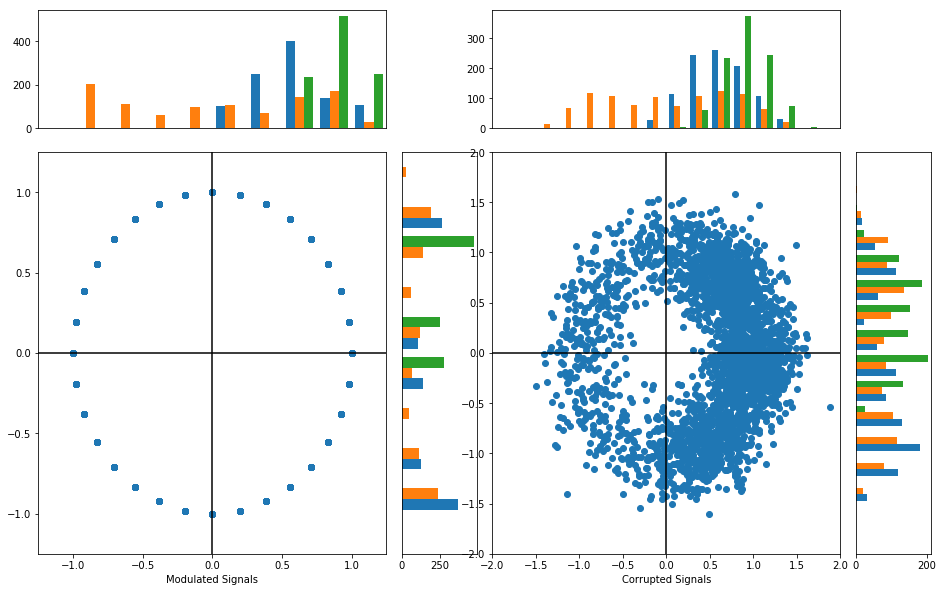

In [5]:
N = 1000
moded_signals = []
corruped_signals = []

# #######################
# Generate examples
# ######################3
for i in range(N):
    msg_bits = generate_message_bits(5)
    
    encoded  = Encoder(msg_bits)
    moded    = Modulator(encoded)
    corruped = AWGNChannel(moded) 
     
    moded_signals.append(moded)
    corruped_signals.append(corruped)
# #######################
# Plot the result
# ######################3    
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(4, 10)

axHistx = fig.add_subplot(gs[0:1,0: 4])
axHistx1 = fig.add_subplot(gs[0:1,5: 9])

axScatter = fig.add_subplot(gs[1:,0:4])
axHisty = fig.add_subplot(gs[1:,4:5])
axScatter1 = fig.add_subplot(gs[1:,5:9])
axHisty1 = fig.add_subplot(gs[1:,9:10])

visualize(moded_signals, axScatter, axHistx, axHisty, 'Modulated Signals')
visualize(corruped_signals, axScatter1, axHistx1, axHisty1, 'Corrupted Signals')